In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from scipy import stats
import statsmodels.api as sm

from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import cross_val_score, KFold
import lightgbm
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_train = pd.read_csv('df_train_30.csv', index_col=[0])
df_test = pd.read_csv('df_test.csv', index_col=[0])

In [3]:
df_train

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure20,SensorMeasure21,RUL,label
0,1,1,0.459770,0.166667,0.0,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.713178,0.724662,191,0
1,1,2,0.609195,0.250000,0.0,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.666667,0.731014,190,0
2,1,3,0.252874,0.750000,0.0,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.627907,0.621375,189,0
3,1,4,0.540230,0.500000,0.0,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.573643,0.662386,188,0
4,1,5,0.390805,0.333333,0.0,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.589147,0.704502,187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,0.477011,0.250000,0.0,0.686747,0.587312,0.782917,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.271318,0.109500,4,1
20627,100,197,0.408046,0.083333,0.0,0.701807,0.729453,0.866475,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.124031,0.366197,3,1
20628,100,198,0.522989,0.500000,0.0,0.665663,0.684979,0.775321,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.232558,0.053991,2,1
20629,100,199,0.436782,0.750000,0.0,0.608434,0.746021,0.747468,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.116279,0.234466,1,1


In [4]:
df_test

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure20,SensorMeasure21,RUL,label
0,1,1,0.632184,0.750000,0.0,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.558140,0.661834,142,0
1,1,2,0.344828,0.250000,0.0,0.150602,0.379551,0.222316,0.805153,0.166667,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.682171,0.686827,141,0
2,1,3,0.517241,0.583333,0.0,0.376506,0.346632,0.322248,0.685990,0.227273,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.728682,0.721348,140,0
3,1,4,0.741379,0.500000,0.0,0.370482,0.285154,0.408001,0.679549,0.196970,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.666667,0.662110,139,0
4,1,5,0.580460,0.500000,0.0,0.391566,0.352082,0.332039,0.694042,0.166667,0.102396,0.273810,0.737740,0.220588,0.152751,0.300885,0.658915,0.716377,138,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.781609,0.500000,0.0,0.611446,0.619359,0.566172,0.573269,0.181818,0.541326,0.500000,0.426439,0.176471,0.584890,0.564063,0.395349,0.418669,24,1
13092,100,195,0.436782,0.416667,0.0,0.605422,0.537388,0.671843,0.542673,0.227273,0.533743,0.446429,0.503198,0.308824,0.572350,0.485956,0.333333,0.528721,23,1
13093,100,196,0.465517,0.250000,0.0,0.671687,0.482014,0.414754,0.513688,0.318182,0.561249,0.428571,0.530917,0.235294,0.605326,0.507888,0.372093,0.429301,22,1
13094,100,197,0.281609,0.583333,0.0,0.617470,0.522128,0.626435,0.566828,0.257576,0.570403,0.452381,0.562900,0.294118,0.622046,0.562524,0.403101,0.518779,21,1


# **Separando os dados em atributos e classes**

In [5]:
# Separando os atributos e a classe do conjunto de treino
df_train_x = df_train.iloc[:,5:18].values
df_train_y = df_train['label'].values

In [6]:
# Separando os atributos e a classe do conjunto de teste
df_test_x = df_test.iloc[:,5:18].values
df_test_y = df_test['label'].values

In [7]:
# Divisão entre treino e teste
df_train_x_treinamento, df_train_x_teste, df_train_y_treinamento, df_train_y_teste = train_test_split(df_train_x, df_train_y, test_size = 0.25, random_state = 0)

# **Treinando modelo sem parâmetros otimizados**

In [8]:
# Light GBM
lgbm = lightgbm.LGBMClassifier()
lgbm.fit(df_train_x_treinamento, df_train_y_treinamento)
previsao= lgbm.predict(df_train_x_teste)

In [9]:
accuracy_score(df_train_y_teste, previsao)

0.9606436603334626

0.9606436603334626

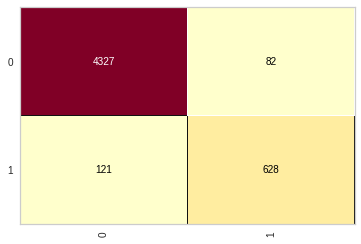

In [10]:
cm = ConfusionMatrix(lgbm)
cm.fit(df_train_x_treinamento, df_train_y_treinamento)
cm.score(df_train_x_teste, df_train_y_teste)

In [11]:
print(classification_report(df_train_y_teste, previsao))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4409
           1       0.88      0.84      0.86       749

    accuracy                           0.96      5158
   macro avg       0.93      0.91      0.92      5158
weighted avg       0.96      0.96      0.96      5158



# **Otimização dos parâmetros no gridsearch**

In [ ]:
parametros= {'num_leaves': [50, 100, 31],
             'learning_rate': [0.5, 1.0, 0.1],
             'n_estimators': [100, 150, 200],
             'min_split_gain': [0, 0.5, 1.0],
             'max_depth': [-1, -2, 5, 10],
             'min_child_samples': [20, 30, 40]}

In [ ]:
grid_search = GridSearchCV(estimator=lightgbm.LGBMClassifier(), param_grid=parametros)
grid_search.fit(df_train_x, df_train_y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 40, 'min_split_gain': 1.0, 'n_estimators': 100, 'num_leaves': 31}
0.9601081207296076


# **Treinando modelo com parâmetros otimizados**

In [12]:
lgbm = lightgbm.LGBMClassifier(num_leaves= 31, learning_rate= 0.1, max_depth= 10, min_split_gain= 1.0, n_estimators= 100, min_child_samples= 40)
lgbm.fit(df_train_x_treinamento, df_train_y_treinamento)
previsao= lgbm.predict(df_train_x_teste)

In [13]:
accuracy_score(df_train_y_teste, previsao)

0.9610314075222954

0.9610314075222954

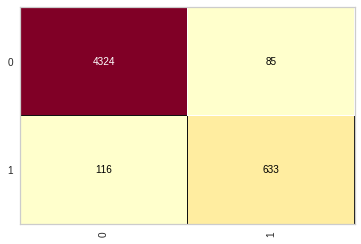

In [14]:
cm = ConfusionMatrix(lgbm)
cm.fit(df_train_x_treinamento, df_train_y_treinamento)
cm.score(df_train_x_teste, df_train_y_teste)

In [15]:
print(classification_report(df_train_y_teste, previsao))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4409
           1       0.88      0.85      0.86       749

    accuracy                           0.96      5158
   macro avg       0.93      0.91      0.92      5158
weighted avg       0.96      0.96      0.96      5158



# **Analisando o modelo otimizado com parâmetro de peso de classe adicionado depois**

In [16]:
lgbm = lightgbm.LGBMClassifier(num_leaves= 31, learning_rate= 0.1, max_depth= 10, min_split_gain= 1.0, n_estimators= 100, min_child_samples= 40, class_weight= 'balanced')
lgbm.fit(df_train_x_treinamento, df_train_y_treinamento)
previsao= lgbm.predict(df_train_x_teste)

In [17]:
accuracy_score(df_train_y_teste, previsao)

0.9451337727801473

0.9451337727801473

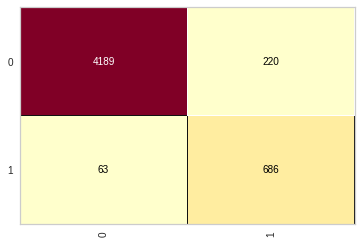

In [18]:
cm = ConfusionMatrix(lgbm)
cm.fit(df_train_x_treinamento, df_train_y_treinamento)
cm.score(df_train_x_teste, df_train_y_teste)

In [19]:
print(classification_report(df_train_y_teste, previsao))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4409
           1       0.76      0.92      0.83       749

    accuracy                           0.95      5158
   macro avg       0.87      0.93      0.90      5158
weighted avg       0.95      0.95      0.95      5158



# **Usando gridsearch com o parâmetro de peso de classe**

In [20]:
parametros= {'num_leaves': [50, 100, 31],
             'learning_rate': [0.5, 1.0, 0.1],
             'n_estimators': [100, 150, 200],
             'min_split_gain': [0, 0.5, 1.0],
             'max_depth': [-1, -2, 5, 10],
             'min_child_samples': [20, 30, 40],
             'class_weight': ['balanced']}

In [21]:
grid_search = GridSearchCV(estimator=lightgbm.LGBMClassifier(), param_grid=parametros)
grid_search.fit(df_train_x, df_train_y)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 30, 'min_split_gain': 0, 'n_estimators': 200, 'num_leaves': 100}
0.9569089432806033


# **Aplicando os parametros otimizados ao modelo com função de custo**

In [22]:
lgbm = lightgbm.LGBMClassifier(num_leaves= 100, learning_rate= 0.1, max_depth= -1, min_split_gain= 0, n_estimators= 200, min_child_samples= 30, class_weight= 'balanced')
lgbm.fit(df_train_x_treinamento, df_train_y_treinamento)
previsao= lgbm.predict(df_train_x_teste)

In [23]:
accuracy_score(df_train_y_teste, previsao)

0.957735556417216

0.957735556417216

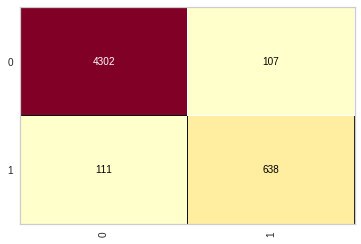

In [24]:
cm = ConfusionMatrix(lgbm)
cm.fit(df_train_x_treinamento, df_train_y_treinamento)
cm.score(df_train_x_teste, df_train_y_teste)

In [25]:
print(classification_report(df_train_y_teste, previsao))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4409
           1       0.86      0.85      0.85       749

    accuracy                           0.96      5158
   macro avg       0.92      0.91      0.91      5158
weighted avg       0.96      0.96      0.96      5158



# **Validação cruzada**

In [ ]:
resultados_lgbm = []
resultados_lgbmfc = []
resultados_lgbmfco = []

for i in range(10):
  kfold = KFold(n_splits=10, shuffle=True, random_state=i)
  
  #modelo com parâmetros otimizados sem peso de classe
  lgbm = lightgbm.LGBMClassifier(num_leaves= 31, learning_rate= 0.1, max_depth= 10, min_split_gain= 1.0, n_estimators= 100, min_child_samples= 40)
  scores = cross_val_score(lgbm, df_train_x, df_train_y, cv = kfold)
  resultados_lgbm.append(scores.mean())

  #modelo com parâmetros otimizados com peso de classe
  lgbmfc = lightgbm.LGBMClassifier(num_leaves= 100, learning_rate= 0.1, max_depth= -1, min_split_gain= 0, n_estimators= 200, min_child_samples= 30, class_weight= 'balanced')
  scores = cross_val_score(lgbmfc, df_train_x, df_train_y, cv = kfold)
  resultados_lgbmfc.append(scores.mean())

  #modelo com parâmetros otimizados com peso de classe adicionado depois
  lgbmfco = lightgbm.LGBMClassifier(num_leaves= 31, learning_rate= 0.1, max_depth= 10, min_split_gain= 1.0, n_estimators= 100, min_child_samples= 40, class_weight= 'balanced')
  scores = cross_val_score(lgbmfco, df_train_x, df_train_y, cv = kfold)
  resultados_lgbmfco.append(scores.mean())

In [ ]:
resultados = pd.DataFrame({'Lgbm': resultados_lgbm, 'lgbmfc': resultados_lgbmfc, 'lgbmfco': resultados_lgbmfco})
resultados

,Lgbm,lgbmfc,lgbmfco
0,0.960787,0.958121,0.947264
1,0.959818,0.958509,0.948282
2,0.960302,0.958800,0.948136
3,0.961272,0.958218,0.948088
4,0.961030,0.958170,0.948282
5,0.960399,0.959139,0.948039
6,0.961078,0.958994,0.947652
7,0.960787,0.958363,0.947554
8,0.960642,0.959237,0.947313
9,0.960787,0.958800,0.948281


In [ ]:
resultados.describe()

,Lgbm,lgbmfc,lgbmfco
count,10.000000,10.000000,10.000000
mean,0.960690,0.958635,0.947889
std,0.000426,0.000414,0.000405
min,0.959818,0.958121,0.947264
25%,0.960460,0.958254,0.947579
50%,0.960787,0.958654,0.948064
75%,0.960969,0.958945,0.948245
max,0.961272,0.959237,0.948282


In [ ]:
# Variância
resultados.var()

Lgbm       1.811129e-07
lgbmfc     1.713988e-07
lgbmfco    1.641210e-07
dtype: float64

In [ ]:
# % de variância
(resultados.std() / resultados.mean()) * 100

Lgbm       0.044299
lgbmfc     0.043187
lgbmfco    0.042739
dtype: float64

# **Avaliando os modelos nos conjundos de dados de teste**

In [ ]:
# modelo sem parâmetro de peso de classe

lgbm = lightgbm.LGBMClassifier(num_leaves= 31, learning_rate= 0.1, max_depth= 10, min_split_gain= 1.0, n_estimators= 100, min_child_samples= 40)
lgbm.fit(df_train_x, df_train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=40, min_child_weight=0.001, min_split_gain=1.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
previsao = lgbm.predict(df_test_x)

In [ ]:
accuracy_score(df_test_y, previsao)

0.9857208307880269

0.9857208307880269

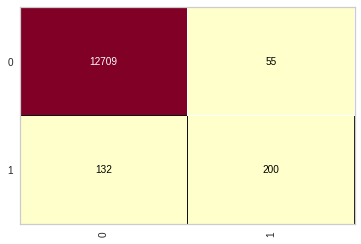

In [ ]:
cm = ConfusionMatrix(lgbm)
cm.fit(df_train_x, df_train_y)
cm.score(df_test_x, df_test_y)

In [ ]:
print(classification_report(df_test_y, previsao))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12764
           1       0.78      0.60      0.68       332

    accuracy                           0.99     13096
   macro avg       0.89      0.80      0.84     13096
weighted avg       0.98      0.99      0.98     13096



In [ ]:
# modelo otimizado com parâmetro de peso de classe

lgbm = lightgbm.LGBMClassifier(num_leaves= 100, learning_rate= 0.1, max_depth= -1, min_split_gain= 0, n_estimators= 200, min_child_samples= 30, class_weight= 'balanced')
lgbm.fit(df_train_x, df_train_y)
previsao = lgbm.predict(df_test_x)

In [ ]:
accuracy_score(df_test_y, previsao)

0.9865607819181429

0.9865607819181429

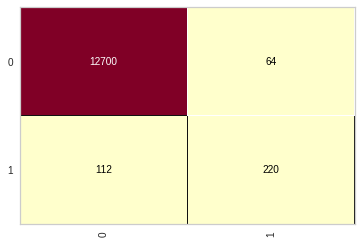

In [ ]:
cm = ConfusionMatrix(lgbm)
cm.fit(df_train_x, df_train_y)
cm.score(df_test_x, df_test_y)

In [ ]:
print(classification_report(df_test_y, previsao))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12764
           1       0.77      0.66      0.71       332

    accuracy                           0.99     13096
   macro avg       0.88      0.83      0.85     13096
weighted avg       0.99      0.99      0.99     13096



In [ ]:
# modelo otimizado com parâmetro de peso de classe adicionado posteriormente

lgbm = lightgbm.LGBMClassifier(num_leaves= 31, learning_rate= 0.1, max_depth= 10, min_split_gain= 1.0, n_estimators= 100, min_child_samples= 40, class_weight= 'balanced')
lgbm.fit(df_train_x, df_train_y)
previsao = lgbm.predict(df_test_x)

In [ ]:
accuracy_score(df_test_y, previsao)

0.9813683567501528

0.9813683567501528

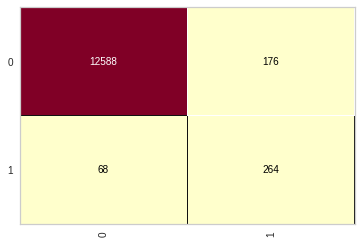

In [ ]:
cm = ConfusionMatrix(lgbm)
cm.fit(df_train_x, df_train_y)
cm.score(df_test_x, df_test_y)

In [ ]:
print(classification_report(df_test_y, previsao))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12764
           1       0.60      0.80      0.68       332

    accuracy                           0.98     13096
   macro avg       0.80      0.89      0.84     13096
weighted avg       0.98      0.98      0.98     13096

